Kaggle 平台：https://www.kaggle.com/c/3rd-ml100marathon-midterm/overview

In [32]:
# 載入所有可能套件 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import copy,time
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from sklearn import metrics, datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_curve
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, Imputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor 
from mlxtend.classifier import StackingClassifier

In [33]:
# 做完特徵工程前的所有準備
df_train = pd.read_csv('data/train_data.csv')
df_test = pd.read_csv('data/test_features.csv')

train_Y = df_train['poi'].astype('int')
ids = df_test['name']
df_train = df_train.drop(['name', 'poi', 'email_address'] , axis=1)
df_test = df_test.drop(['name','email_address'] , axis=1)
df = pd.concat([df_train, df_test])
df.head()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,1750000.0,NaN,-3504386.0,NaN,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,5600000.0,NaN,NaN,NaN,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,200000.0,NaN,-4167.0,NaN,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,800000.0,NaN,NaN,NaN,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,1250000.0,NaN,-262500.0,NaN,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


In [34]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
na_check(df)

,Missing Ratio
loan_advances,97.260274
director_fees,88.356164
restricted_stock_deferred,87.671233
deferral_payments,73.287671
deferred_income,66.438356
long_term_incentive,54.794521
bonus,43.835616
from_this_person_to_poi,41.095890
from_poi_to_this_person,41.095890
from_messages,41.095890


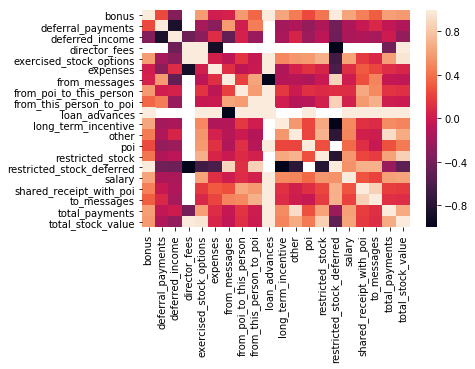

['bonus', 'deferral_payments', 'deferred_income', 'exercised_stock_options', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'salary', 'total_payments', 'total_stock_value']


In [35]:
# 計算df整體相關係數, 排除不相關的變數
df_train2 = pd.read_csv('data/train_data.csv')
df2 = df_train2.drop(['name','email_address'] , axis=1)
corr = df2.corr()
sns.heatmap(corr)
plt.show()

# 篩選相關係數大於 0.2 或小於 -0.2 的特徵
high_list = list(corr[(corr['poi']>0.2) | (corr['poi']<-0.2)].index)
high_list.remove('poi')
print(high_list)

In [36]:
df = df[high_list]

# 部分欄位缺值填補 0
zero_cols = ['bonus', 'deferral_payments', 'deferred_income', 'exercised_stock_options', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'salary', 'total_payments', 'total_stock_value']
for col in zero_cols:
    df[col] = df[col].fillna(0)

In [37]:
na_check(df)
df.head()

,Missing Ratio


,bonus,deferral_payments,deferred_income,exercised_stock_options,loan_advances,long_term_incentive,other,restricted_stock,salary,total_payments,total_stock_value
0,1750000.0,0.0,-3504386.0,19794175.0,0.0,1617011.0,174839.0,2748364.0,420636.0,505050.0,22542539.0
1,5600000.0,0.0,0.0,19250000.0,0.0,1920000.0,22122.0,6843672.0,1111258.0,8682716.0,26093672.0
2,200000.0,0.0,-4167.0,1624396.0,0.0,0.0,1573324.0,869220.0,211844.0,2003885.0,2493616.0
3,800000.0,0.0,0.0,0.0,0.0,602671.0,907502.0,985032.0,224305.0,2652612.0,985032.0
4,1250000.0,0.0,-262500.0,0.0,0.0,375304.0,486.0,126027.0,240189.0,1639297.0,126027.0


In [45]:
# 將資料最大最小化
df = MinMaxScaler().fit_transform(df)

# 將前述轉換完畢資料 df , 重新切成 train_X, test_X
train_num = train_Y.shape[0]
train_X = df[:train_num]
test_X = df[train_num:]

# 使用三種模型 : 邏輯斯迴歸 / 梯度提升機 / 隨機森林, 參數使用 Random Search 尋找
lr = LogisticRegression(tol=0.001, penalty='l2', fit_intercept=True, C=1.0)
gdbt = GradientBoostingClassifier(tol=100, subsample=0.75, n_estimators=100, max_features=5,
                                  max_depth=3, learning_rate=0.03)
rf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1, 
                            max_features='sqrt', max_depth=6, bootstrap=True)

In [46]:
# 邏輯斯迴歸預測檔 (結果有部分隨機, 請以 Kaggle 計算的得分為準)
lr.fit(train_X, train_Y)
lr_pred = lr.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': ids, 'poi': lr_pred})
sub.to_csv('Enron Fraud_lr.csv', index=False)

In [47]:
# 梯度提升機預測檔 (結果有部分隨機, 請以 Kaggle 計算的得分為準)
gdbt.fit(train_X, train_Y)
gdbt_pred = gdbt.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': ids, 'poi': gdbt_pred})
sub.to_csv('Enron Fraud_gdbt.csv', index=False)

In [48]:
# 隨機森林預測檔 (結果有部分隨機, 請以 Kaggle 計算的得分為準)
rf.fit(train_X, train_Y)
rf_pred = rf.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': ids, 'poi': rf_pred})
sub.to_csv('Enron Fraud_rf.csv', index=False)

In [50]:
# 混合泛化預測檔 
blending_pred = lr_pred*0.8  + gdbt_pred*0.15 + rf_pred*0.05
sub = pd.DataFrame({'name': ids, 'poi': blending_pred})
sub.to_csv('Enron Fraud_blending.csv', index=False)